In [240]:
# %matplotlib notebook
# %pylab

In [241]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Generating the 2D Data

In [242]:
import pickle
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
import itertools

### Experiment Function

In [243]:
STEP ='STEP'
EPISODE = 'EPISODE'
QUADRATIC='QUADRATIC'
COSINE ='COSINE'
CURRENT='CURRENT'# reward in state
DELAYED='DELAYED' # discounted future reward
CURRENT_DELAYED ='CURRENT_DELAYED' # current reward + discounted future reward

In [244]:
from experiment import *
name = "LimitedJump_1000_1DQ"
parameters={
            "exp": name,            #name of experiment
            "mode": EPISODE,           # two modes of execution, 1 episode(1000steps) or N episodes -[step, episode] 
            "data_dimension": 2,    # dimension of data, 1 to N Dimension
            "function":QUADRATIC,   # quadratic or cosine
            "queue_length": 5,      # max length of queue
            "heuristic_queue":2,    # sequeuce length that is considered by the heuristic
            "discount_factor": 0.5, # discount factor               
            "max_skip":100,           # maximum allowed skip 
            "e_start": 1,           # episilon value to start applying heuristic
            "e_stop":0,             # episilon value to stop applying heuristic
            "epi": 20,             # number of episodes
            "learning_rate": 0.9,   # learning rate
            "reward":CURRENT,       # current/delayed/current_delayed
            "lambda":0.01,
            "min_skip":3, 
            "baseline":True,        # parameter to switch to baseline model(without heuristic)
            "num_step":1000
        }

create_experiment(parameters)

In [245]:
exp = view_experiment(name)

In [246]:
def styblinski_tang(x):
    """
    compute styblinski-tang optimization test function

    Args:
        x(array): array to compute the styblinki_tang value of

    Returs:
        the evaluated value of styblinki_tang function of x
    """
    result = x**4 - 16 * x**2 + 5 * x
    return result / 2



def rosenbrock(x):
    """
    Compute Rosenbrock test function for a single point

    Args:
        x(array): array to compute the rosenbrock value of

    Returs:
        the evaluated value of rosenbrock function of x
    """
    #print(x)
    #result = np.sum(100.0 * (x[1:] - x[:-1]**2.0) ** 2.0 + (1 - x[:-1])**2.0, axis=0)
    result = 100*(x[1]-x[0]**2)**2 + (x[0]-1)**2
    return result


def quadratic(x):
    """
    Compute quadratic test function for a single point

    Args:
        x(array): array to compute the rosenbrock value of

    Returs:
        the evaluated value of quadratic function of x
    """
    result = np.sum(0.3*x**2 -5, axis=0)

    return result

def camelback(x):
    #print(x)
    return ((4-2.1*x[0]**2 + (x[0]**4)/3)*x[0]**2 + x[0]*x[1] + (-4+4*(x[1]**2))*x[1]**2)

def griewank(x):
    return (x[0]**2)/4000+(x[1]**2)/4000 - np.cos(x[0])-np.cos(x[1]/2)+1

def eason(x):
    return -np.cos(x[0])*np.cos(x[1])*np.exp(-(x[0]-np.pi)**2-(x[1]-np.pi)**2)

def egg_holder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]**2 + x[0]/2 + 47))) - x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))
    
def array_map(f, x):
    return np.array(list(map(f, x)))

def quadratic_2d(x):
    A = np.matrix([[1, 0],[0, 2]])
    b = np.matrix([[0],[0]])
    c = 0
    return float(0.5 * x.T * A * x - b.T * x + c)

In [247]:
def bowl(f):
    fig = plt.figure(figsize=(10,8))
    qf = fig.gca(projection='3d')
    
    x1 = list(np.arange(-5, 6, 1))
    x2 = list(np.arange(-5, 6, 1))
    size = len(x1)
    x1, x2 = np.meshgrid(x1, x2)
    zs = np.zeros((size, size))
    collector = []
    value = []
    for i in range(size):
        for j in range(size):
            x = np.matrix([[x1[i,j]], [x2[i,j]]])
            collector.append([x1[i,j], x2[i,j]])
            zs[i,j] = f(x)
            value .append(zs[i,j])
    qf.plot_surface(x1, x2, zs, rstride=1, cstride=1, linewidth=0)
    fig.show()
    return x1, x2, zs, collector, value

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


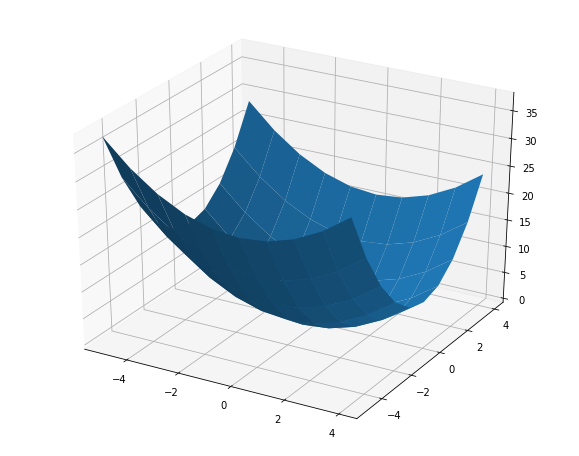

In [248]:
x1, x2, data, collector, value = bowl(quadratic_2d)

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


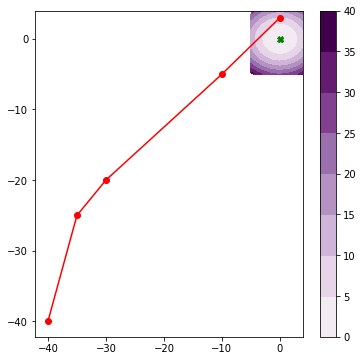

In [249]:
from matplotlib import cm

def contoursteps(x1, x2, zs, steps=None):
    fig = plt.figure(figsize=(6,6))
    levels = np.arange(-2.0, 1.601, 0.4)
    norm = cm.colors.Normalize(vmax=abs(zs).max(), vmin=-abs(zs).max())
    cmap = cm.PRGn
    cmap=cm.get_cmap(cmap, len(levels) - 1)
    cp = plt.contourf(x1, x2, zs, norm = norm, cmap=cmap.reversed())
    plt.plot(0, 0, 'X', color='green')
    fig.colorbar(cp)
    #plt.clabel(cp, inline=1, fontsize=10)
    if steps is not None:
        step =steps
        steps = np.matrix(steps)
        plt.plot(steps[:,0], steps[:,1], '-o', color='red')
#     for i, txt in enumerate(len(step)):
#         fig.annotate(value, (z[i], y[i]))
    fig.show()
    
steps = [(-40,-40),(-35,-25), (-30,-20),(-10,-5),(0,3)]
contoursteps(x1, x2, data, steps)

In [250]:
data_df = pd.DataFrame({"collector":collector,"duration":value})


In [251]:
data_df.tail()

,collector,duration
95,"[0, 4]",16.0
96,"[1, 4]",16.5
97,"[2, 4]",18.0
98,"[3, 4]",20.5
99,"[4, 4]",24.0


# Reinforcement learning notebook

In [252]:
# from libiopa.jobmodel import databuilder
# from libiopa.tools import dbconnector
# import pandas as pd

# collections = dbconnector.connect('lima16',27017,'cmdb_database','JobItem','FileIOSummary')
# dict_db = dbconnector.load_collections(collections)

In [253]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize
# from sklearn.preprocessing import MinMaxScaler

In [254]:
class Job:
    def __init__(self, data):
        self.runs = data
        self.preparationRuns()
        
    def preparationRuns(self):
        
        min_dur = min(self.runs['duration'])
        max_dur = max(self.runs['duration'])
        self.runs['durationNorm'] = (self.runs['duration']-min_dur)/(max_dur-min_dur)


    def getStateAndRewardById(self, run_id):

        state = self.runs.T[run_id]
        
        
        return (state['collector'], 1/(state['durationNorm']+0.02))

job1 = Job(data_df)

### Exponential Function

In [255]:
import math
class LinearDecaySchedule(object):
    def __init__(self, initial_value, final_value, max_steps):
        assert initial_value > final_value, "initial_value should be > final_value"
        self.initial_value = initial_value
        self.final_value = final_value
        self.decay_factor = (initial_value - final_value) / max_steps

    def __call__(self, step_num):
        current_value = self.final_value + math.exp(-exp['lambda'] * step_num)
        if current_value < self.final_value:
            current_value = self.final_value
        return current_value

20


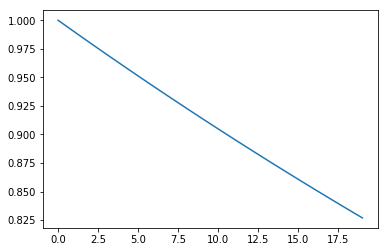

In [256]:
epsilon_initial = 1.0
epsilon_final = 0.
MAX_NUM_EPISODES = exp['epi']
print(MAX_NUM_EPISODES)
MAX_STEPS_PER_EPISODE = 50
linear_sched = LinearDecaySchedule(initial_value = epsilon_initial,
                                final_value = epsilon_final,
                                max_steps = MAX_NUM_EPISODES )
epsilon = [linear_sched(step) for step in range(MAX_NUM_EPISODES )]
plt.plot(epsilon)
plt.show()

### Heuristic Function

In [257]:
def get_direction(start, end):
    #convert to numpy arrays
    start = np.array(start)
    end=np.array(end)
    
    # find the vector
    v = start - end
    
    if v[0]!=0:
        if v[0]> 0:
            return 2
        else:
            return 1
    elif v[1]!=0:
        if v[1]>0:
            return 3
        else:
            return 4
    else:
        return 0
    
    
get_direction([2,3],[1,3])

2

In [258]:
def heuristic_weight1(queue_list, n, clip=1000):
    if len(queue_list)==5:
        last_3 = queue_list[-n:]
        deltas =[]
        value_deltas=[]
        min_skip = exp['min_skip']
        # check whether succesive actions are given an increased reward
        for i in range(n-1):
            delta = last_3[i][1]< last_3[i+1][1]
            value_delta = last_3[i+1][1] - last_3[i][1]
            deltas.append(delta)
            value_deltas.append(value_delta)
        if all(deltas):
            # get all 3 successive actions
            all_states = []
            for a in range(len(queue_list)):
                all_states.append(queue_list[a][0])
            all_states= all_states[-n:]
            last_value_delta = value_deltas[-1]
            action_skip = np.round((1+last_value_delta)*min_skip)
            
            if action_skip>clip:
                action_skip=clip
            #print(all_states,get_direction(all_states[0],all_states[1]), action_skip)
            
            return get_direction(all_states[1], all_states[0]), action_skip
        else:
            return -1, -1
    else:
        return -1,-1

In [259]:
def get_inter_states(start, end):
    '''This function assumes that the state change in one dimension 
    only'''
    assert len(start)== len(end)
    
    if np.array_equal(start, end):
        return [start, end]
    dim = len(start)
    start_a = np.array(start)
    end_a = np.array(end)
    vector = end_a - start_a
    dim_change = [i for i, elem in enumerate(vector) if elem!=0][0]

    result =[]
    result.append(start_a)
    last = result[-1]
    sign = -1 if end[dim_change] < start[dim_change] else 1
    
    st = list(range(start[dim_change], end[dim_change]+sign, sign))
    final_states=[]
    for x in st:
        b=np.zeros(shape=(1, dim))
        for i in range(0, dim):
            if i!= dim_change:
                b[0][i] = start[i]
        b[0][dim_change] = x    
        final_states.append(list(b[0]))
    return final_states

    
        
        
        
get_inter_states([0,0], [0,4])

[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [0.0, 4.0]]

### Environment

In [260]:
# TOOLS

def isin2D(a, b):
    """
        Check the existance of elements of a in b
        return an array : a boolean for each element of a
    """
    boolArray = []
    for i in a:
        present = False
        j = 0
        while present == False and j < len(b):

            if np.array_equal(i, b[j]):
                present = True
            j += 1
        boolArray.append(present)
    return boolArray

In [261]:
from collections import deque

class Environment:
    def __init__(self, Job):
        self.job = Job

        self.state = None
        self.reward = None
        self.done = False
        self.def_actions()
        self.d = deque([], maxlen=exp['queue_length'])
        self.reset_env()

    def def_actions(self):
        """
            Define all combinations possibles with 3 numbers in {-2,0,2}
            Creates the list in self.actions
        """
        self.actions=[
            [0,0],
            [-1,0],
            [1,0],
            [0,1],
            [0,-1]
        ]
        
        return self.actions

    def check_if_action_possible(self, a):
        """
            For each action, check if it is possible to apply to the current state :
            apply the action on the currect state and check if the new state is defined
            in the run dataFrame !!!!!! WILL BE CHANGED !!!
        """
#         return np.arange(len(self.actions))
        result_actions = [np.add(self.state, a) ]
        possible = isin2D(result_actions, np.array(self.job.runs['collector']))
        #print(possible)
        return possible[0]

    def get_reward(self, state):
        reward = -1000
        for r in self.job.runs.T:
            if np.array_equal(self.job.runs['collector'][r], state):
                state, reward = self.job.getStateAndRewardById(r)
        return reward
    
    def check_actions_possible(self):
        """
            For each action, check if it is possible to apply to the current state :
            apply the action on the currect state and check if the new state is defined
            in the run dataFrame !!!!!! WILL BE CHANGED !!!
        """
        result_actions = [np.add(self.state, a) for a in self.actions]
        possible = isin2D(result_actions, np.array(
            self.job.runs['collector']))

        return np.where(np.array(possible) == True)[0]

    def do_action(self, action_id, esp=1, verbose = False, train=True):
        """
            Apply the action defined by action_id.
            Changes the current_state
            Returns (new_state,reward of the action, Done boolean, debug info)
        """
        if not action_id in self.check_actions_possible():
            return (None, -1000, False, {}, action_id)

        params_actual = self.state
        action = self.actions[action_id]
        new_action = action
        action_weight = 1
        if esp <=exp['e_start'] and train==True and exp['baseline']==False:
            queue_list = list(self.d)
            new_action_id, action_weight=heuristic_weight1(queue_list, exp['heuristic_queue'], exp['max_skip'])
            
            if new_action_id != -1:
                new_action = self.actions[new_action_id]
                status= self.check_if_action_possible(np.array(new_action)*action_weight)
                if status == False:
                    action_weight = 1
                    new_action = action
                else:
                    action_id=new_action_id
                
         
            else:
                new_action = action
                action_weight=1
                
        if esp<=exp['e_stop']:# stop applying the heuristic
            new_action = action
            action_weight=1

        new_params = np.add(params_actual, (np.array(new_action)*action_weight))
        for r in self.job.runs.T:
            if np.array_equal(self.job.runs['collector'][r], new_params):
                self.state, self.reward = self.job.getStateAndRewardById(r)
                if verbose:
                    print("New state : {0} {1} duration {2}".format(r,self.state[1],self.job.runs['duration'][r]))
                return (self.state, self.reward, self.decide_done(action_id), {}, action_id)

        raise Exception('Pas normal pour le moment !!!')
        return None
    
    def reset_env(self):
        """ Initialize the environment to a random job """
        run_id = np.random.choice(self.job.runs.T.keys())
        self.state, self.reward = self.job.getStateAndRewardById(run_id)
        
        self.previous_action = None
        self.nb_actions = 0
        
        return self.state
    
    def set_state(self,state):
        self.reset_env()
        self.state = state
        return state
    
    def decide_done(self,a):
        """
            Decide when the environment is done:
            - no convergence : more than 50 actions since reset
            - stay on the same state more than twice            
        """
        self.nb_actions+=1
        action = self.actions[a]
        if exp['mode']==EPISODE:
            done = self.nb_actions > 50
        else:
            done = self.nb_actions > int(exp['num_step'])
        return done
    
    def list_states(self):
        params = np.array(self.job.runs['collector'])
        return params
        

env = Environment(job1)

In [262]:
env.check_actions_possible()

array([0, 2, 3, 4])

In [263]:
import keras
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Masking, CuDNNLSTM, Dropout, Activation, Input, Concatenate

In [264]:
from keras import backend as K
import tensorflow as tf

# # allocate only a part of the GPU
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.05
# config.log_device_placement = True
# config.allow_soft_placement = True
# sess = tf.Session(config=config)
# K.set_session(sess)

# Deep Q learning

In [265]:
class ModelDQN():
    def __init__(self, nb_metrics, nb_actions):
        self.nb_metric = nb_metrics
        self.nb_actions = nb_actions
        self.model = self.defModel(nb_metrics, nb_actions)

    @staticmethod
    def huber_loss(y_true, y_pred):
        HUBER_LOSS_DELTA = 1.0
        err = y_true - y_pred

        cond = K.abs(err) < HUBER_LOSS_DELTA
        L2 = 0.5 * K.square(err)
        L1 = HUBER_LOSS_DELTA * (K.abs(err) - 0.5 * HUBER_LOSS_DELTA)

        # Keras does not cover where function in tensorflow :-(
        loss = tf.where(cond, L2, L1)

        return K.mean(loss)

    @staticmethod
    def defModel(nb_metrics, nb_actions):
        """
            Definition of the keras model
            TODO : stateful
        """
#         seq = Input(shape=(None, nb_metrics))
        params = Input(shape=(2,))

        params_part = Dense(5)(params)
#         params_part = Dropout(0.2)(params_part)
        params_part = Dense(10)(params_part)
        params_part = Dense(10)(params_part)
        params_part = Dense(10)(params_part)


        out = Dense(nb_actions)(params_part)

        model = Model(inputs=[params], outputs=[out])
        model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
        return model

    def transformInput(self, seq, params):
        """
            Transform the sequence to put into the model
        """
        return np.array([params])

    def fit(self, state, vector, epochs=1, verbose=0):
        """
            Fit the model with the given state
        """
        params = self.transformInput(None, state)
        h = self.model.fit(params, np.array(
            [vector]), epochs=epochs, batch_size=1, verbose=verbose)
        return h

    def prepareBatchSeq(self, seqs):
        """
            Pad the sequences of a batch to have the same length
            !!!!!! todo : modifier pour le statefull !!!!!! 
        """
        max_len = max([len(x) for x in seqs])
        return sequence.pad_sequences(seqs, maxlen=max_len, dtype='float64', padding='post', value=-1.0)

    def fit_batch(self, state, vector, batch_size, epochs=1, verbose=0):
        """
            Fit the model with the given state
        """
        params = np.array(state)
#         seq = self.prepareBatchSeq(seq)
        params = [np.array(x) for x in params]
        params = np.array(params)
        vector = np.array(vector)
        h = self.model.fit(params, vector, epochs=epochs,
                           batch_size=batch_size, verbose=verbose)
        return h

    def predict(self, state, batch_size=1):
        """
            Predict the vector for a given state
        """
        params = self.transformInput(None, state)
        return self.model.predict(params, batch_size)
    
    def predict_batch(self, state):
        """
            Predict the vector for a given state
        """
#         params = self.transformInput(None, state)
        return self.model.predict(state, batch_size=len(state))


model = ModelDQN(10, len(env.actions))

In [266]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_106 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_107 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_108 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_109 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_110 (Dense)            (None, 5)                 55        
Total params: 350
Trainable params: 350
Non-trainable params: 0
_________________________________________________________________


In [267]:
import time

In [268]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.memory_actions = dict()
        self.memory_best = list()  # contains the list action 0 of the best states

    def append(self, state, action, reward, next_state, done):
        if len(self.memory) > self.capacity:
            self.pop()
        self.memory.append((state, action, reward, next_state, done))

        ## append in dict
        key_dict = state.tobytes()
        if not key_dict in self.memory_actions.keys():
            self.memory_actions[key_dict] = np.zeros(5)  # todo use variable for nb_actions
        self.memory_actions[key_dict][action] += 1

        # new best list: if best empty or if better than best
        if len(self.memory_best) == 0 or self.memory_best[0][2] < reward:
            self.memory_best = list()
            self.memory_best.append((next_state, 0, reward, next_state, False))
        # if equal to best reward : append to the list
        elif len(self.memory_best) > 0 and self.memory_best[0][2] == reward:
            self.memory_best.append((next_state, 0, reward, next_state, False))

    def pop(self):
        old_elem = self.memory[0]
        state_key = old_elem[0].tobytes()
        action = old_elem[1]
        self.memory.pop(0)
        self.memory_actions[state_key][action] -= 1

    def sample(self, n):
        # select n-1 elements from memory
        idxs = np.random.choice(np.arange(len(self.memory)), size=n-1)

        # select 1 element from best list
        idx_best = np.random.choice(np.arange(len(self.memory_best)), size=1)

        mem_samples = np.array(self.memory)[idxs]
        mem_best = np.array(self.memory_best)[idx_best]
        full = np.append(mem_samples,mem_best,axis=0)
        return full

    def listActionsForState(self, state):
        state_key = np.array(state).tobytes()
        actions = []
        if state_key in self.memory_actions.keys():
            actions = np.where(self.memory_actions[state_key] > 0)[0]

        return np.array(actions)

In [269]:
import time
from time import strftime

In [270]:
class AgentDoubleQ:
    def __init__(self, env, model1, model2):
        self.memory = Memory(10000)
        self.sample_batch_size = 32
        self.env = env
        self.model1 = model1
        self.model2 = model2 # target net
        
    def decision(self, state, exploration_rate):
        if np.random.random() < exploration_rate:
            possible_actions = np.arange(len(self.env.def_actions()))
            actionDone = self.memory.listActionsForState(state)
            setActions = np.setdiff1d(possible_actions, actionDone)
            if len(setActions) == 0:
                setActions = possible_actions          
            return np.random.choice(setActions)
        else:
            # choose the max reward in the possible actions
            values = self.model1.predict(state)[0]
            return np.argmax(values)
        
    def remember(self, state, action, reward, next_state, done):
        """
            Put the state, the action, the new state and the reward into the memory
        """
        if not next_state is None:
            next_state=next_state
        self.memory.append(
            np.array(state), action, reward, next_state, done)
        
    def replay(self):
        batch = self.memory.sample(self.sample_batch_size)

        no_state = np.zeros(2)
        states1 = np.array([i for i in batch[:,0]])
        print(states1.shape)
        states2 = np.array([ (no_state if i is None else i) for i in batch[:,3] ])

        p_state1 = self.model2.predict_batch(states1)
        p_state2 = self.model2.predict_batch(states2)
        pmax_state2 = self.model1.predict_batch(states2)

        batch_states = []
        batch_actions = []
        for i,(state, action, reward, next_state, done) in enumerate(batch):
            gama = 0.9
            if next_state is None:
                target = reward
            else:
                b_action = np.argmax(pmax_state2[i])
                target = reward + gama * p_state2[i][b_action]

            Q = p_state1[i]
            Q[action] = target
            batch_states.append(state)
            batch_actions.append(Q)
            
        self.model1.fit_batch(batch_states, batch_actions, self.sample_batch_size)
    
    def run(self, start_state, num_episode):
        MAX_EPSILON = 1
        MIN_EPSILON = 0.01
        LAMBDA = exp['lambda']  # speed of decay
        
        states_visited = [ list() for _ in range(num_episode)]
        index_max = np.ones(num_episode)*51
        sum_reward = np.zeros(num_episode)
        nb_max = np.zeros(num_episode)
        
        UPDATE_TARGET_FREQUENCY = 100
        steps = 0
        
        for i in range(num_episode):
            print("Episode {0} out of {1}".format(i+1, num_episode))
            if start_state is None:
                state = self.env.reset_env()
            else:
                state = self.env.set_state(start_state)
                
            done = False
            #exploration_rate = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * i)
            exploration_rate = linear_sched(i)
            states_visited[i].append(state)
            nb_actions = 0
            while not done:
                action = self.decision(state, exploration_rate)
                steps += 1
                next_state, reward, done, _, action = self.env.do_action(action, exploration_rate)
                sum_reward[i]+=reward
                
                if next_state is not None:
                    states_visited[i].append(state)
                    self.env.d.append((action,reward))
                    state = next_state
                    self.remember(state, action, reward, next_state, done)
                #self.replay()
                if i > 10:
                    self.replay()
                
                if steps % UPDATE_TARGET_FREQUENCY == 0:
                    self.model2.model.set_weights(self.model1.model.get_weights())
                
                nb_actions += 1
                if reward == 50.0 and index_max[i] == 51:
                    index_max[i] = nb_actions
                if reward == 50.0:
                    nb_max[i] += 1
                    
            #exploration_rate = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * i)
                
        return {
            'index_max_reward': index_max,
            'states_visited':states_visited,
            'nb_max' : nb_max,
            'sum_rewards' : sum_reward
        }
        


In [271]:
model1 = ModelDQN(10, len(env.actions))
model2 = ModelDQN(10, len(env.actions))
a = AgentDoubleQ(env, model1, model2)
states = env.list_states()
t0 = time.time()
res = a.run(start_state=(states[0]), num_episode=exp['epi'])
t1 = time.time()
print("done {0}".format((t1-t0)/60))

Episode 1 out of 20
Episode 2 out of 20
Episode 3 out of 20
Episode 4 out of 20
Episode 5 out of 20
Episode 6 out of 20
Episode 7 out of 20
Episode 8 out of 20
Episode 9 out of 20
Episode 10 out of 20
Episode 11 out of 20
Episode 12 out of 20
(32, 2)
Instructions for updating:
Use tf.cast instead.
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
Episode 13 out of 20
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)
(32, 2)


In [272]:
res['states_visited'][9]

[[-5, -5],
 [-5, -5],
 [-4, -5],
 [-4, -4],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-4, -4],
 [-4, -5],
 [-5, -5],
 [-5, -4],
 [-4, -4],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-5, -4],
 [-4, -4],
 [-5, -4],
 [-4, -4],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-5, -4],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-4, -4],
 [-4, -5],
 [-4, -4],
 [-4, -5],
 [-5, -5],
 [-4, -5],
 [-5, -5],
 [-5, -4],
 [-4, -4],
 [-5, -4],
 [-5, -5],
 [-4, -5],
 [-4, -4]]

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


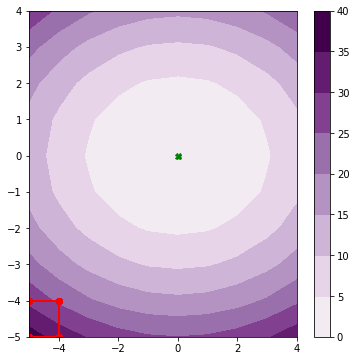

In [273]:
contoursteps(x1,x2, data, res['states_visited'][9])

In [274]:
import pickle
def save_results(filename, data):
    filename = 'trained_results/'+filename +'.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    return True
def load_results(filename):
    filename = 'trained_results/'+filename +'.pkl'
    with open(filename, 'rb') as f:
        b = pickle.load(f)
    return b

In [275]:
#save_results('deep2d_b_200',res)

In [276]:
#rd = load_results('deep2d_b_200')

FileNotFoundError: [Errno 2] No such file or directory: 'trained_results/deep2d_b_200.pkl'

In [ ]:
contoursteps(x1,x2, data, rd['states_visited'][15])

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['index_max_reward']
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * i) for i in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('steps', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Variation of the number of step to get the optimum with epsilon \nstart : {0} , lambda={1}'.format(states[80],LAMBDA))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['nb_max']

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step) for step in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('steps', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Variation of the number of step the agent stayed in the optimum per episode \nstart : {0} '.format(states[0]))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['sum_rewards']

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step) for step in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('sum', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Sum of rewards per episode \nstart : {0} '.format(states[80]))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
dimFixe = 1 # dimension fixe : 1 for binsize
fixVal = states[1][80][dimFixe]
idx = np.where(np.array([i for i in job1.runs['accelerators']])[:,dimFixe]==fixVal)[0]
accels = [ i for i in np.array(job1.runs['accelerators'])[idx]]
accels = np.delete(accels, dimFixe, 1)

duration = 1/(np.array(job1.runs['durationNorm'])[idx]+0.02)

In [ ]:
def plot(list_episodes,index_episode,all_before=False,indicator='r-'):
    Z = duration.reshape(8, 5)
    fig, ax = plt.subplots()
    c = ax.pcolor(Z)
    fig.colorbar(c, ax=ax)

    if all_before == False:
        episodes = [list_episodes[index_episode]]
    else:
        episodes = np.array(list_episodes)[np.arange(index_episode+1)]
        
    for e in episodes:
        points = np.delete(np.array(e),dimFixe,1)
        ax.plot(points[:,0]/2-0.5,points[:,1]/2,indicator,alpha=0.5*1/len(episodes)+0.2)
    plt.show()

interact(plot, 
         list_episodes=fixed(res['states_visited']), 
         index_episode=widgets.IntSlider(min=0,max=len(res['states_visited'])-1,step=1,value=10),
         indicator = ['r-','r+']
        );

In [ ]:
## 50 Episodes
## liste des états dans list_states
s = np.array(env.set_state((states[0][80], states[1][80])))
list_states = []
list_states.append(s[1])
done = False
while not done:
    action = a.decision(s,0)
    next_s, r, done, _ = env.do_action(action)
    print(r)
    if not next_s is None:
        list_states.append(next_s[1])
    s = next_s
plot([list_states],0,all_before=False)